In [34]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch

In [35]:
base_dir = Path("../data_out/default_finn").resolve()

# Generate residual datasets

In [36]:
c_train = np.load(base_dir / "c_train.npy")
c_predictions = np.load(base_dir / "c_predictions.npy")
residuals = c_train - c_predictions

NOISE_SIGMA = 0# 8e-4  # 4e-4 is the lowest I can go since otherwise there will be too large gaps
print(f"{residuals.min():.2e}, {residuals.max():.2e}, {residuals.mean():.2e}, {np.median(np.abs(residuals)):.2e}")

-2.08e-03, 2.07e-03, -1.30e-05, 3.04e-05


In [37]:
# add noise to predictions to make the data points for the pos/neg residuals more uniform
c_predictions += np.random.normal(0, NOISE_SIGMA, c_predictions.shape)
residuals = c_train - c_predictions
residuals.shape

(51, 2, 26, 1)

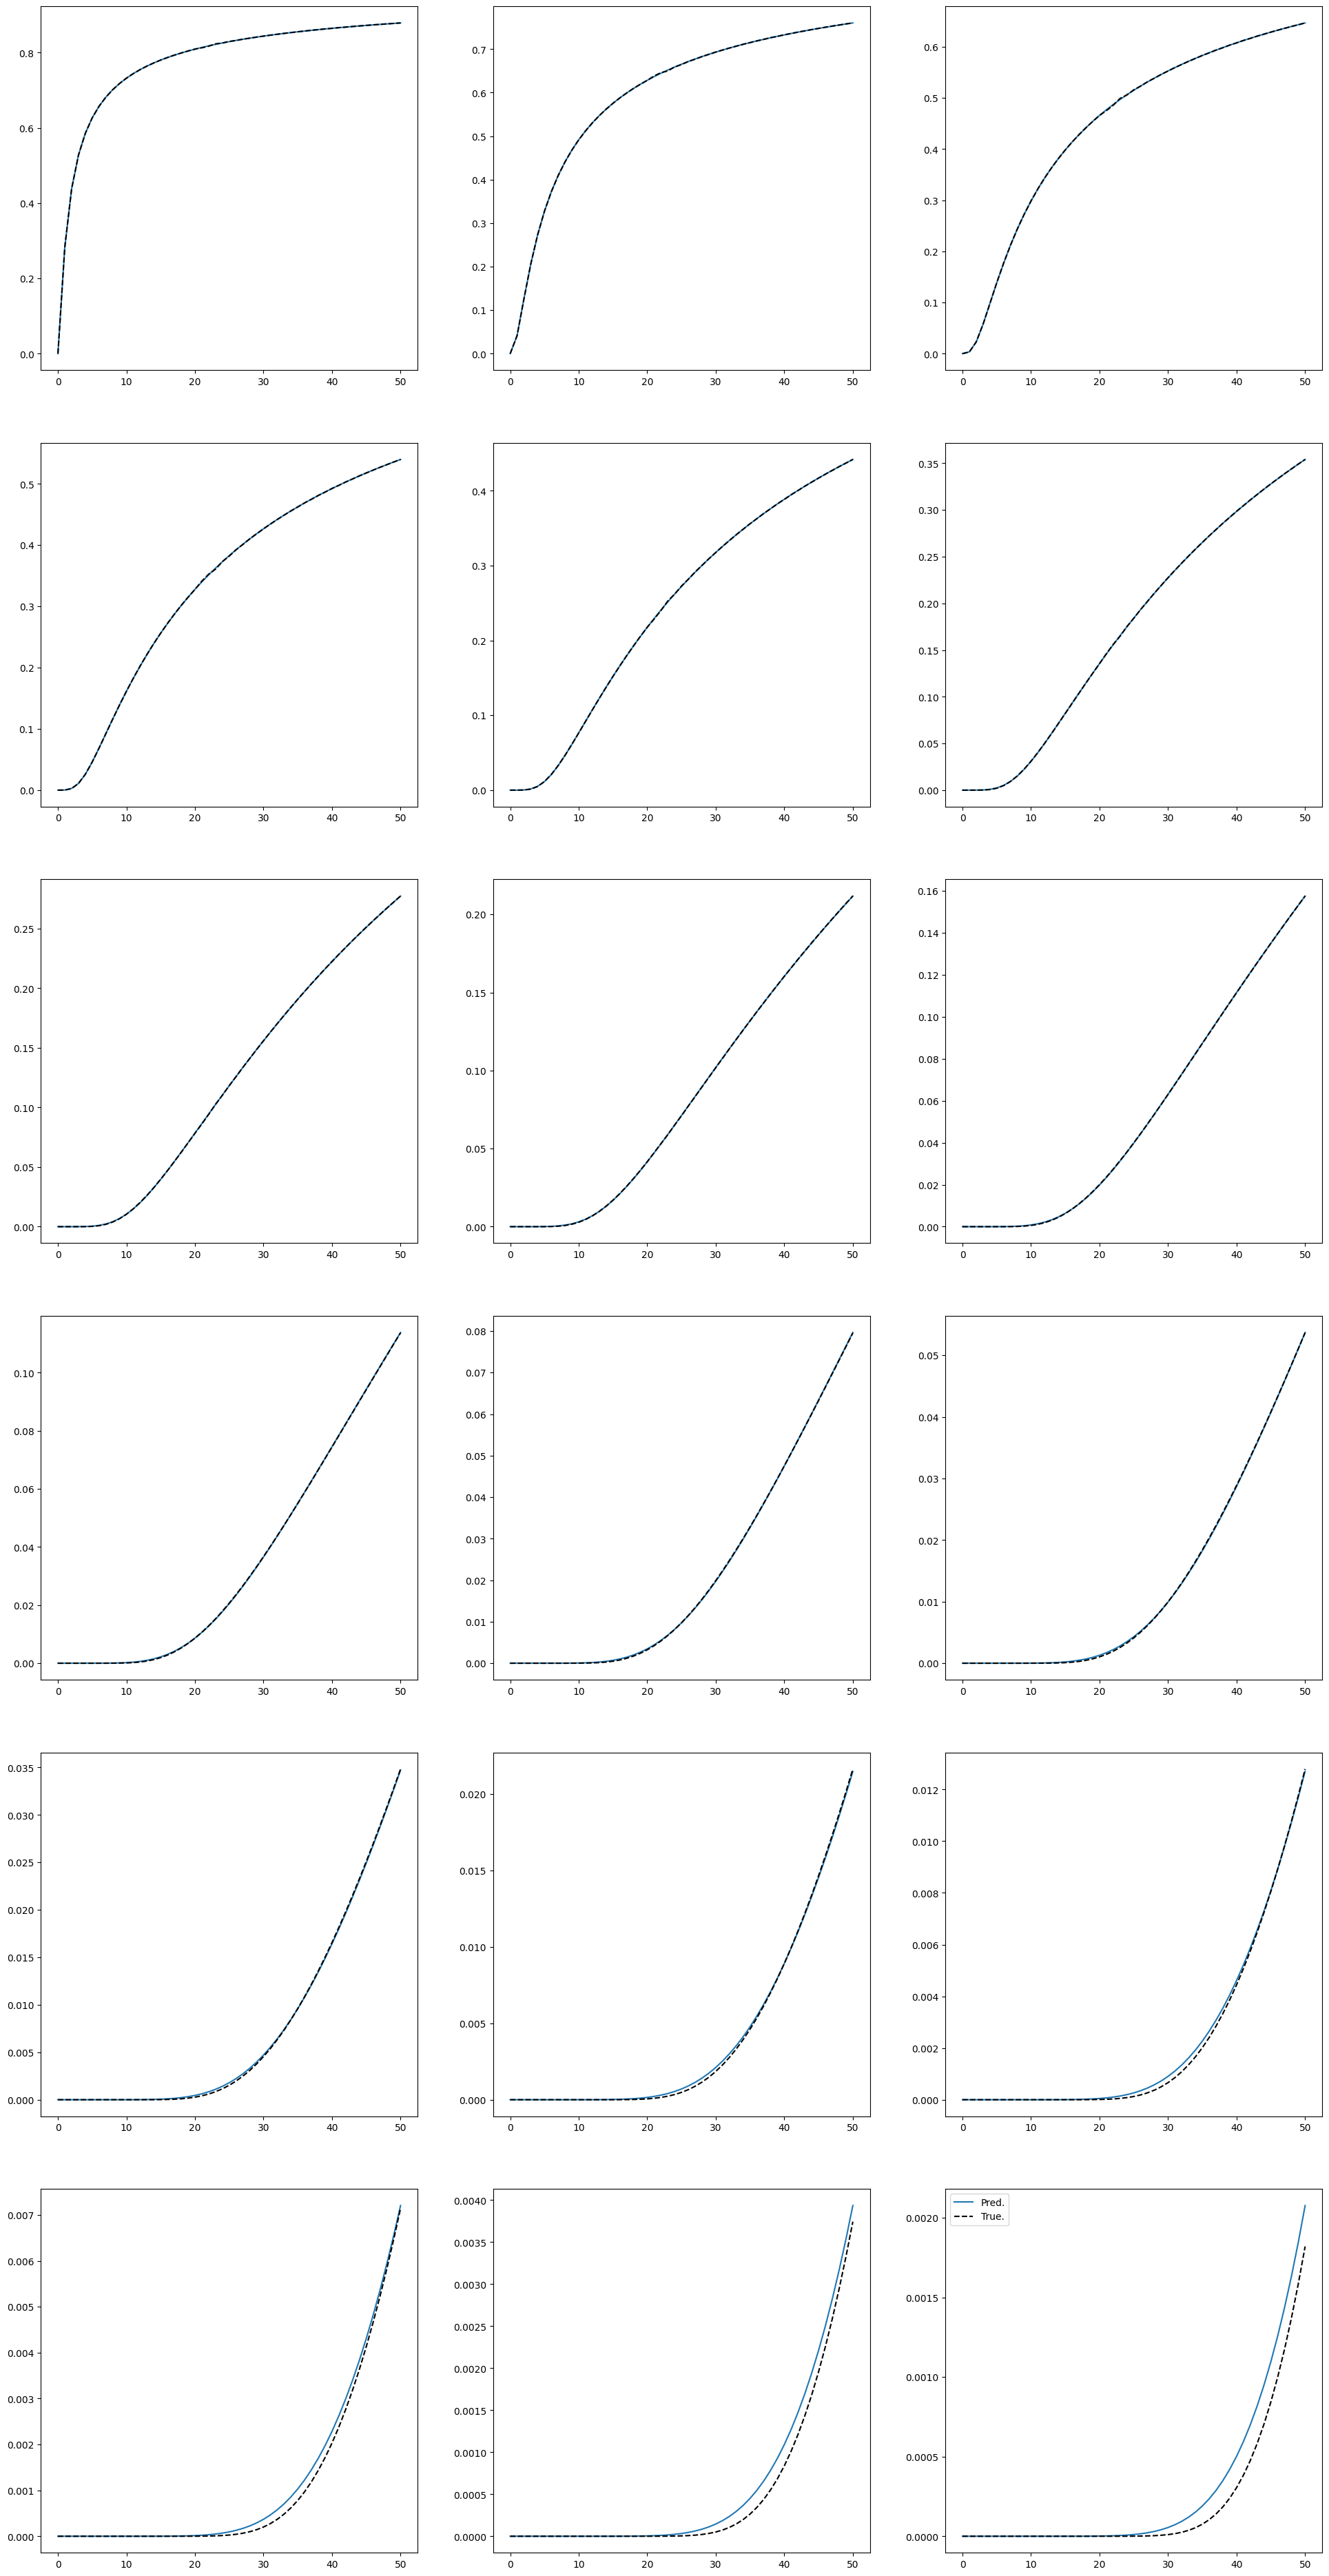

In [38]:
from math import ceil
ncols = 3
nrows = ceil(26/5)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for i, ax in zip(range(c_train.shape[2]), axs):
    ax.plot(c_predictions[:, 0, i, 0], label="Pred.")
    ax.plot(c_train[:, 0, i, 0], "k--", label="True.")
plt.legend()
plt.show()

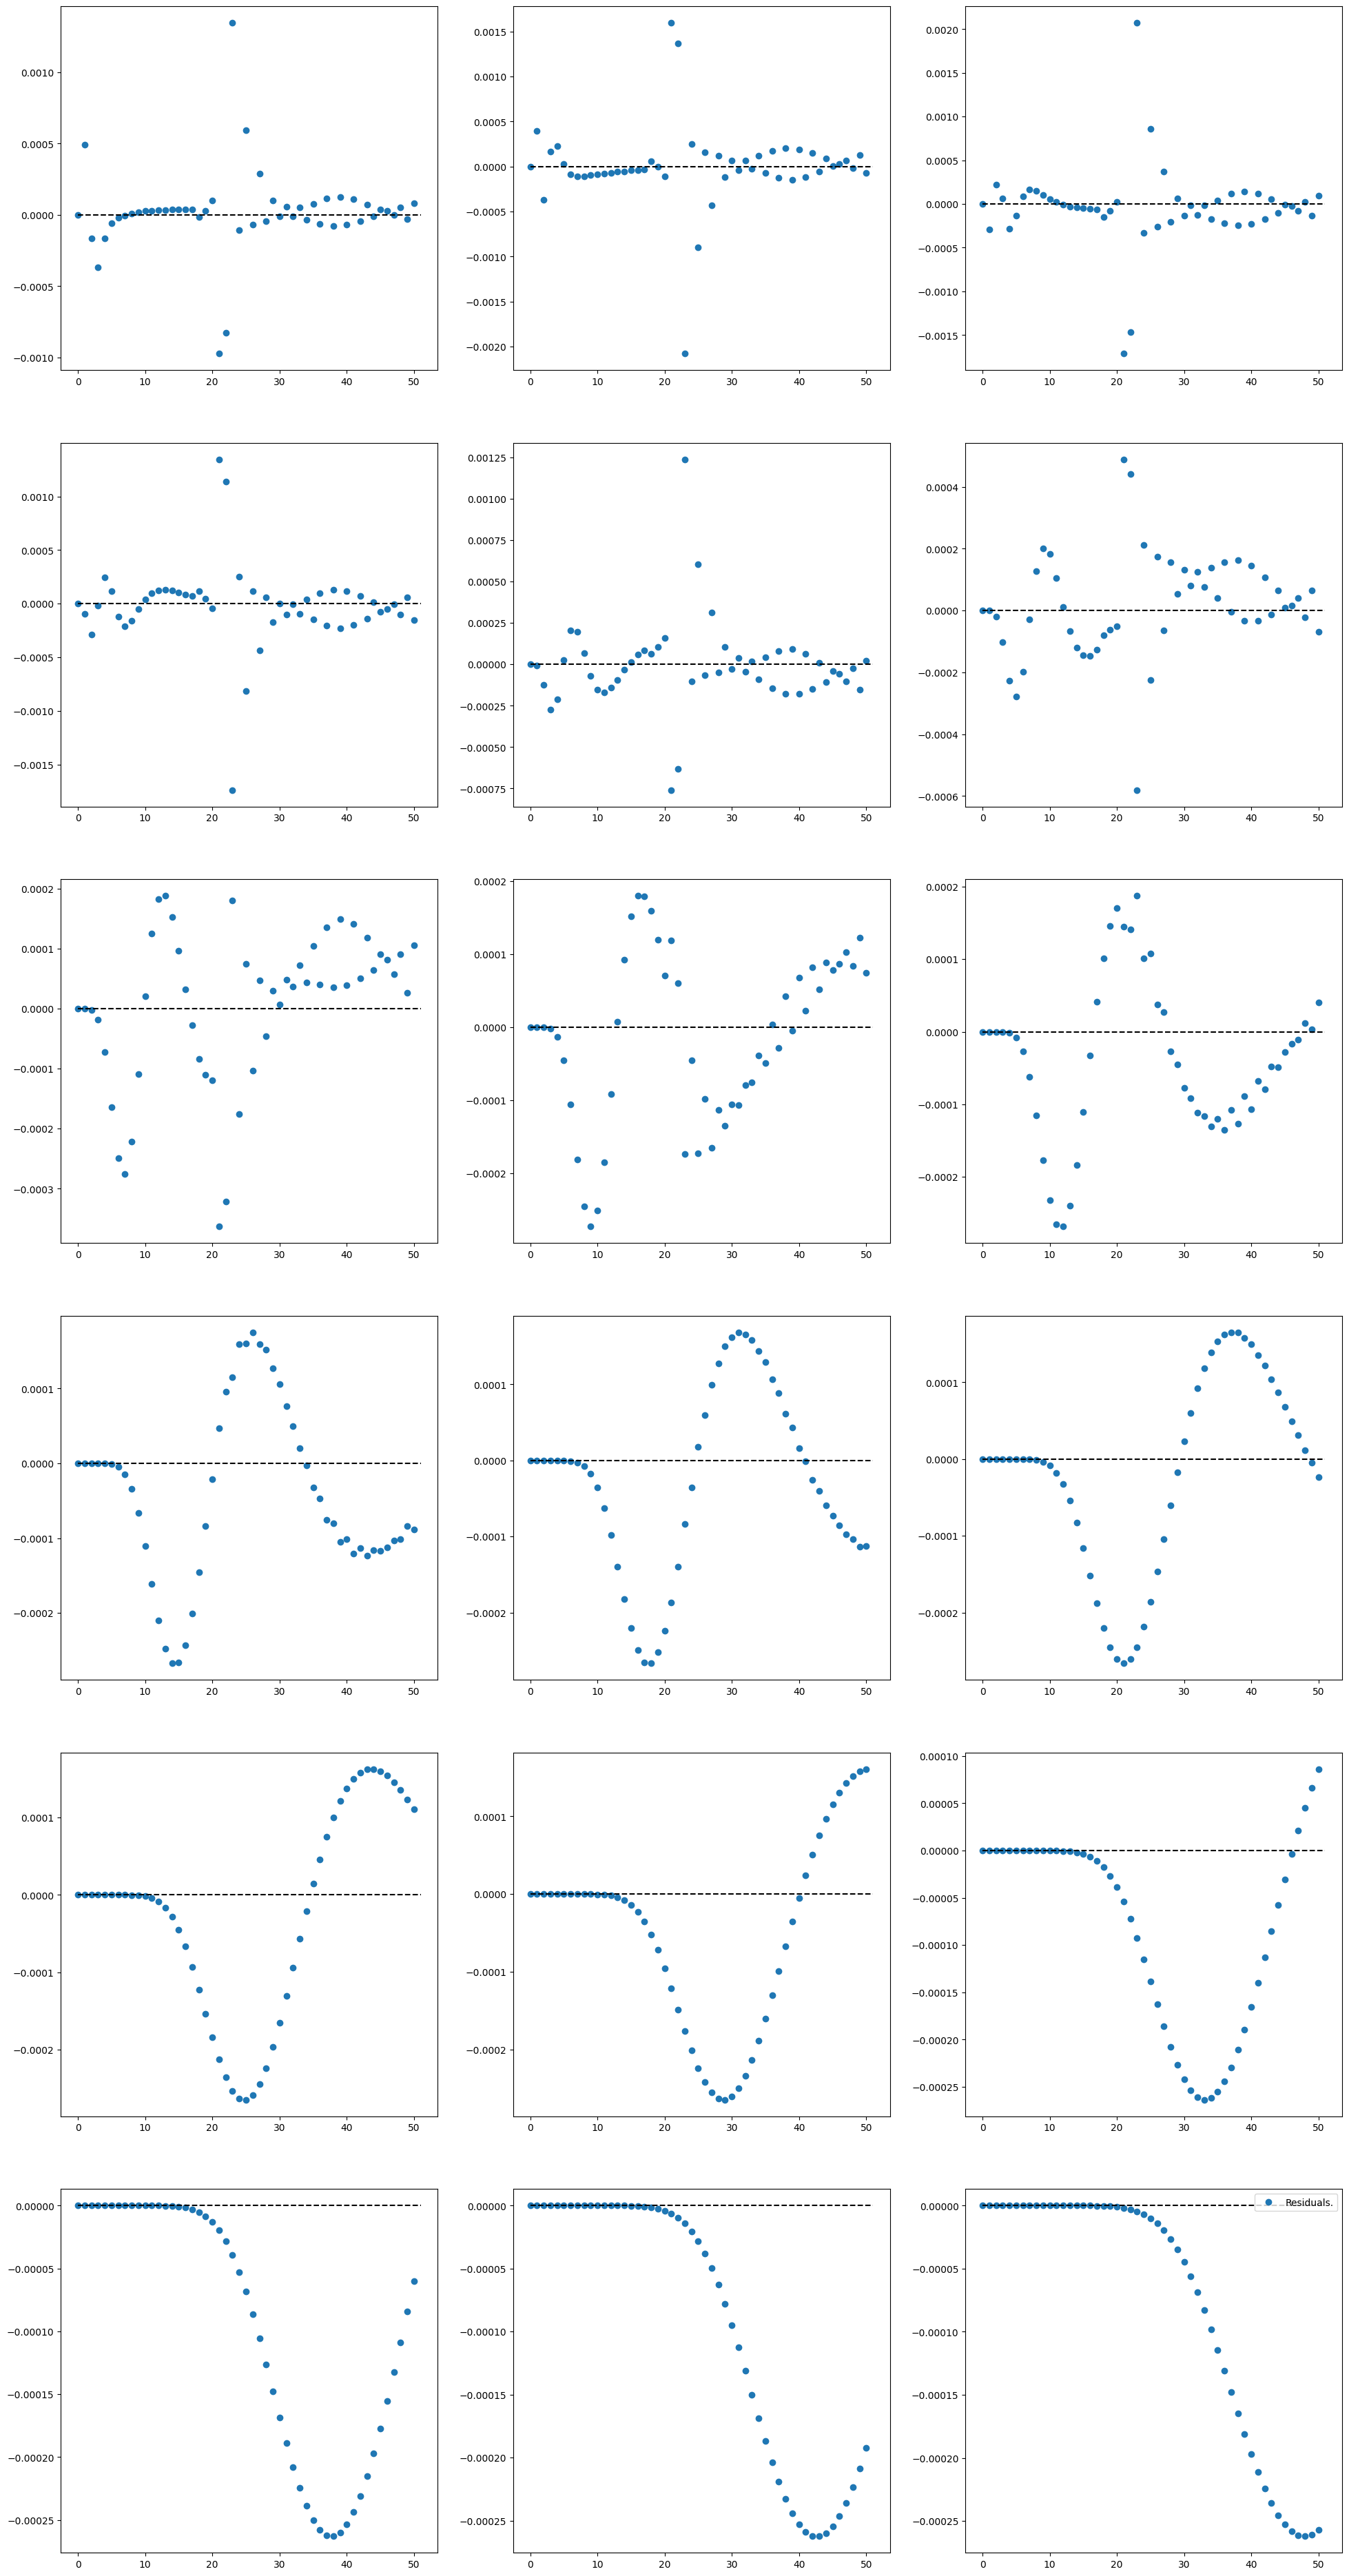

In [39]:
from math import ceil
ncols = 3
nrows = ceil(26/5)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols,8*nrows))
axs = axs.flatten()
for i, ax in zip(range(c_train.shape[2]), axs):
    ax.plot(residuals[:, 0, i, 0], "o", label="Residuals.")
    ax.hlines(0, 0, c_train.shape[0], color="k", linestyle="--")
plt.legend()
plt.show()

### Predictions without Noise

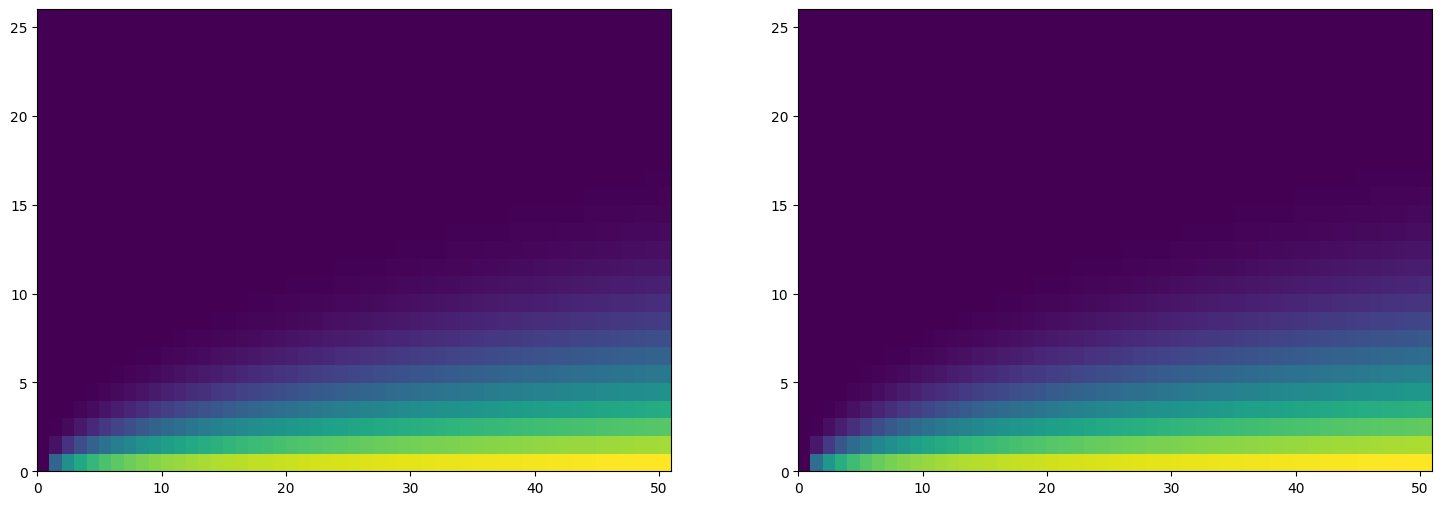

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor(c_predictions[:, 0, :, 0].T)
ax2.pcolor(c_predictions[:, 1, :, 0].T)
plt.show()

### Residuals without Noise

0.0020788908


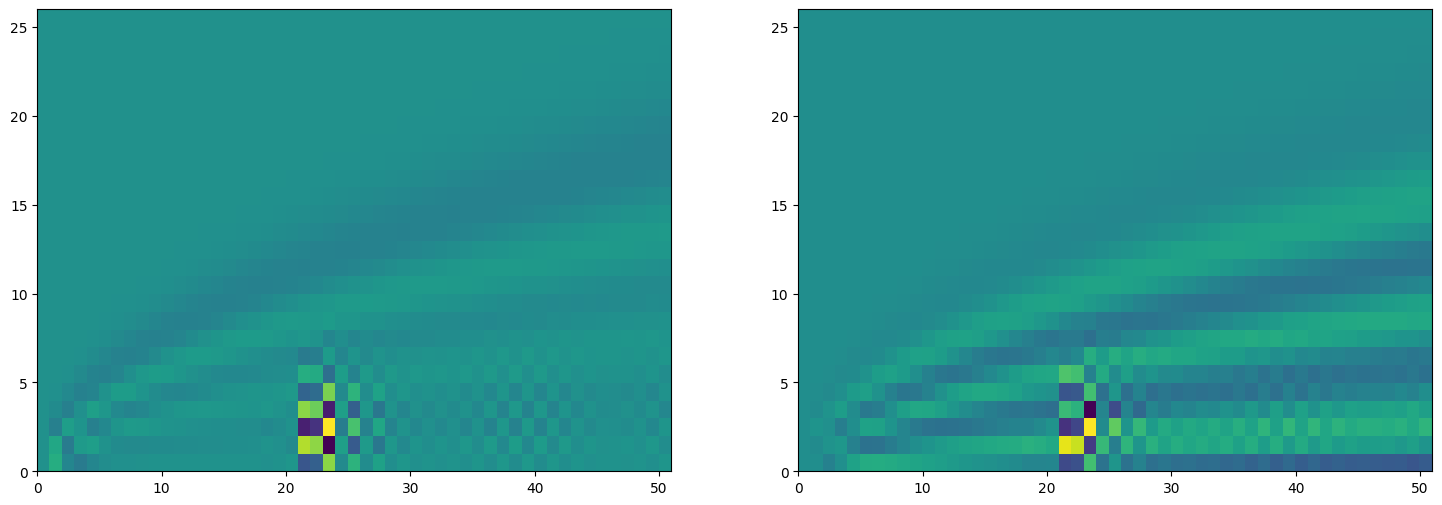

In [41]:
print(np.abs(c_train - c_predictions).max())
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor(((c_train - c_predictions)[:, 0, :, 0]).T)
ax2.pcolor(((c_train - c_predictions)[:, 1, :, 0]).T)
plt.show()

## Results with Noise

### Residual Sign

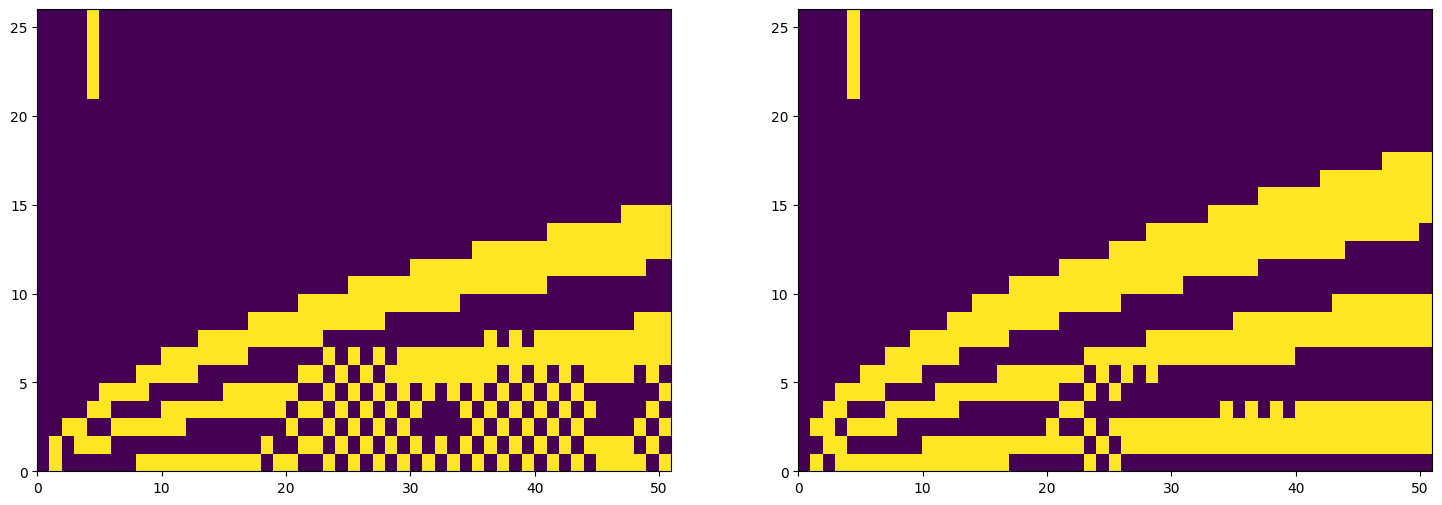

In [42]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
ax1.pcolor((residuals[:, 0, :, 0] > 0).T)
ax2.pcolor((residuals[:, 1, :, 0] > 0).T)
plt.show()

### Residuals

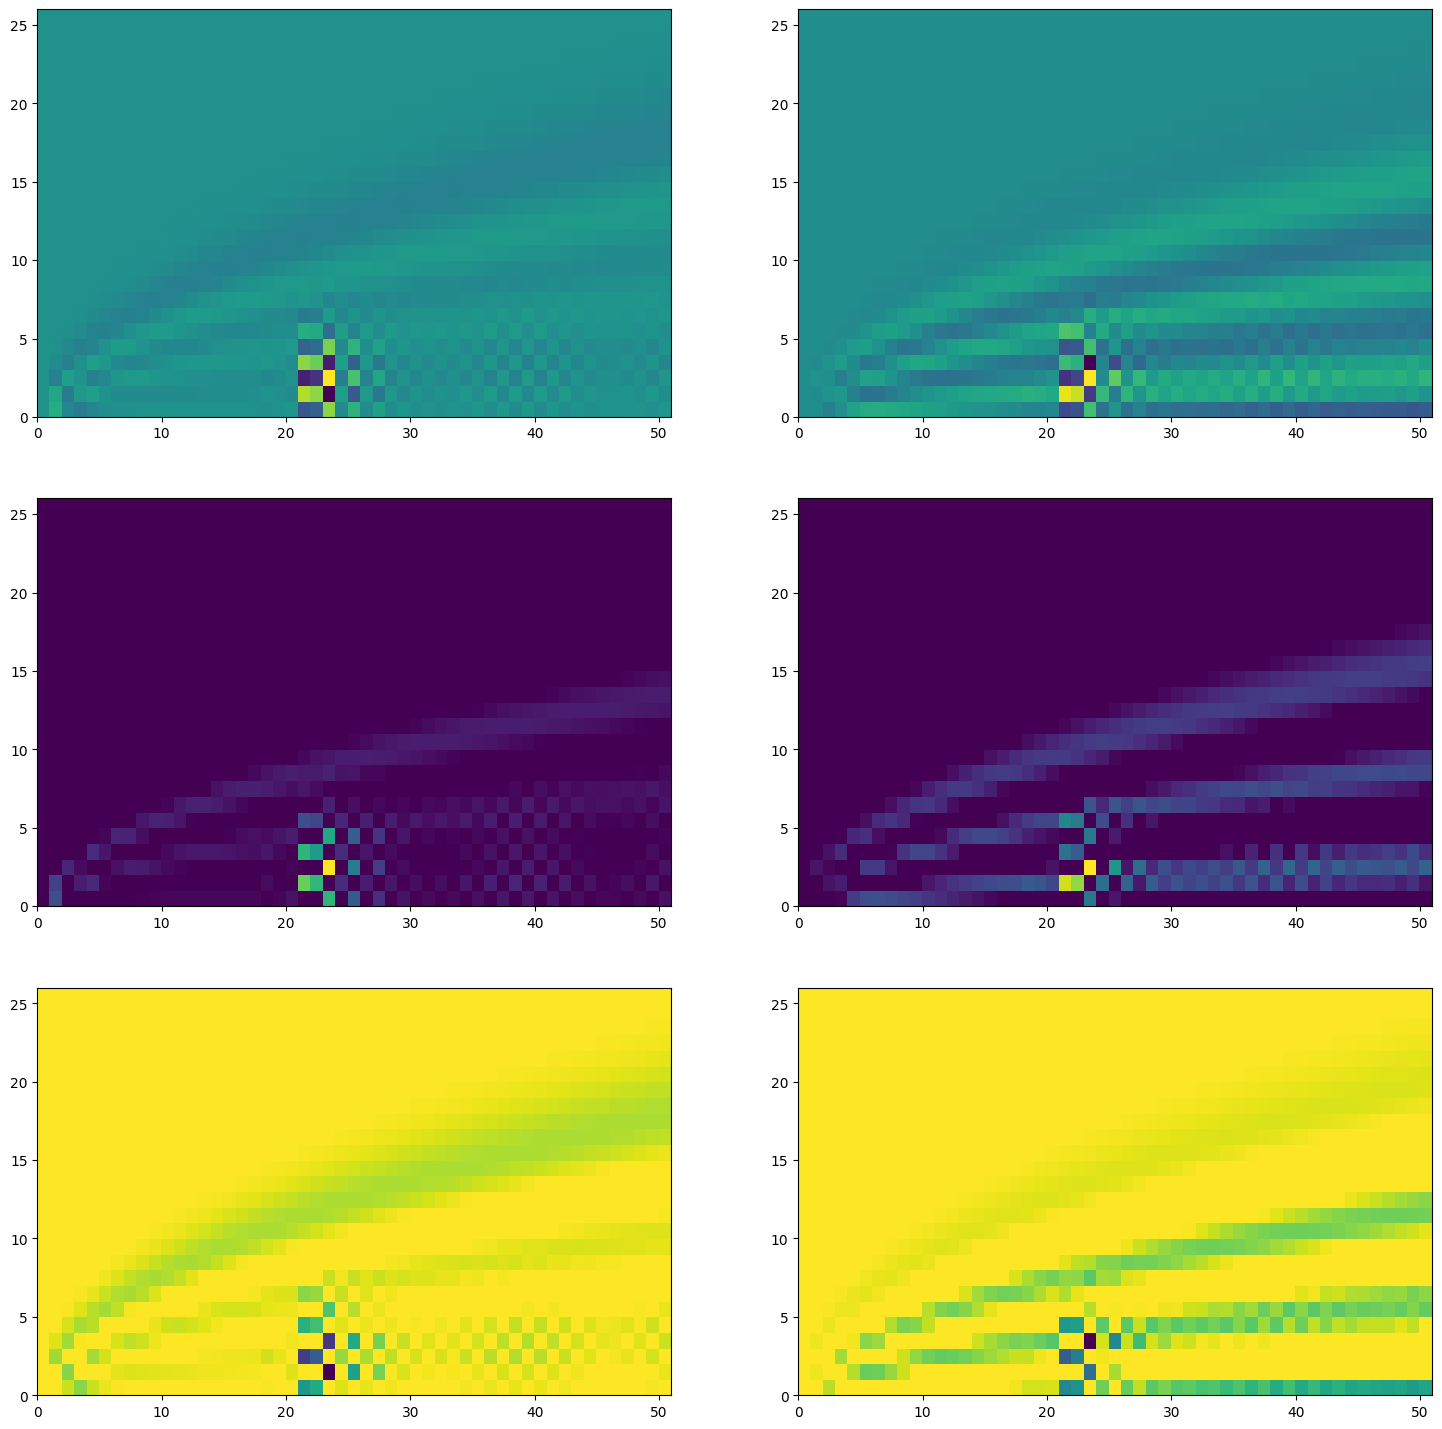

In [43]:
fig, axs = plt.subplots(nrows = 3, ncols=2, figsize=(18,18))
axs[0, 0].pcolor((residuals[:, 0, :, 0]).T)
axs[0, 1].pcolor((residuals[:, 1, :, 0]).T)

axs[1, 0].pcolor(np.clip(residuals[:, 0, :, 0], 0, 1e100).T)
axs[1, 1].pcolor(np.clip(residuals[:, 1, :, 0], 0, 1e100).T)

axs[2, 0].pcolor(np.clip(residuals[:, 0, :, 0], -1e100, 0).T)
axs[2, 1].pcolor(np.clip(residuals[:, 1, :, 0], -1e100, 0).T)
plt.show()

In [44]:
median_diss = np.median(residuals[:, 0, ...])
median_tot = np.median(residuals[:, 1, ...])
residuals[:, 0, ...] -= median_diss
residuals[:, 1, ...] -= median_tot

np.save(base_dir / "residual_medians.npy", np.array([median_diss, median_tot]))

In [45]:
is_res_pos = residuals > 0
is_res_pos.shape

(51, 2, 26, 1)

In [46]:
print(np.count_nonzero(is_res_pos))
print(np.count_nonzero(~is_res_pos))
print()
print(np.count_nonzero(is_res_pos[:, 0, ...]))
print(np.count_nonzero(~is_res_pos[:, 0, ...]))
print()
print(np.count_nonzero(is_res_pos[:, 1, ...]))
print(np.count_nonzero(~is_res_pos[:, 1, ...]))

1326
1326

663
663

663
663


In [47]:
import params

In [48]:
t_train = np.load(base_dir / "t_train.npy")
t = t_train
x = np.linspace(0.0, params.X, params.Nx)

X_pos = ([], [])
X_neg = ([], [])
Y_pos = ([], [])
Y_neg = ([], [])
X_pos_test = ([], [])
X_neg_test = ([], [])
for i in range(residuals.shape[0]):
    for j in range(residuals.shape[2]):
        for k in range(residuals.shape[1]):
            if is_res_pos[i, k, j, 0]:
                X_pos[k].append([t[i], x[j]])
                X_neg_test[k].append([t[i], x[j]])
                Y_pos[k].append(residuals[i, k, j, 0])
            else:
                X_neg[k].append([t[i], x[j]])
                X_pos_test[k].append([t[i], x[j]])
                Y_neg[k].append(residuals[i, k, j, 0])

In [49]:
output_path = base_dir / "residual_training_data"
output_path.mkdir(exist_ok=True, parents=True)
for k, suffix in enumerate(["diss", "tot"]):
    np.save(output_path / f"X_pos_train_{suffix}.npy", np.array(X_pos[k]))
    np.save(output_path / f"X_neg_train_{suffix}.npy", np.array(X_neg[k]))
    np.save(output_path / f"Y_pos_train_{suffix}.npy", np.array(Y_pos[k]))
    np.save(output_path / f"Y_neg_train_{suffix}.npy", np.array(Y_neg[k]))

    np.save(output_path / f"X_pos_test_{suffix}.npy", np.array(X_pos_test[k]))
    np.save(output_path / f"X_neg_test_{suffix}.npy", np.array(X_neg_test[k]))

# Analyze predictions

In [50]:
from common import plot_c, plot_c_timeseries, plot_c_spaceseries

In [51]:
np.abs(residuals).max()

0.0020783679

In [52]:
print(c_predictions.shape)

(51, 2, 26, 1)


### Predictions with Noise

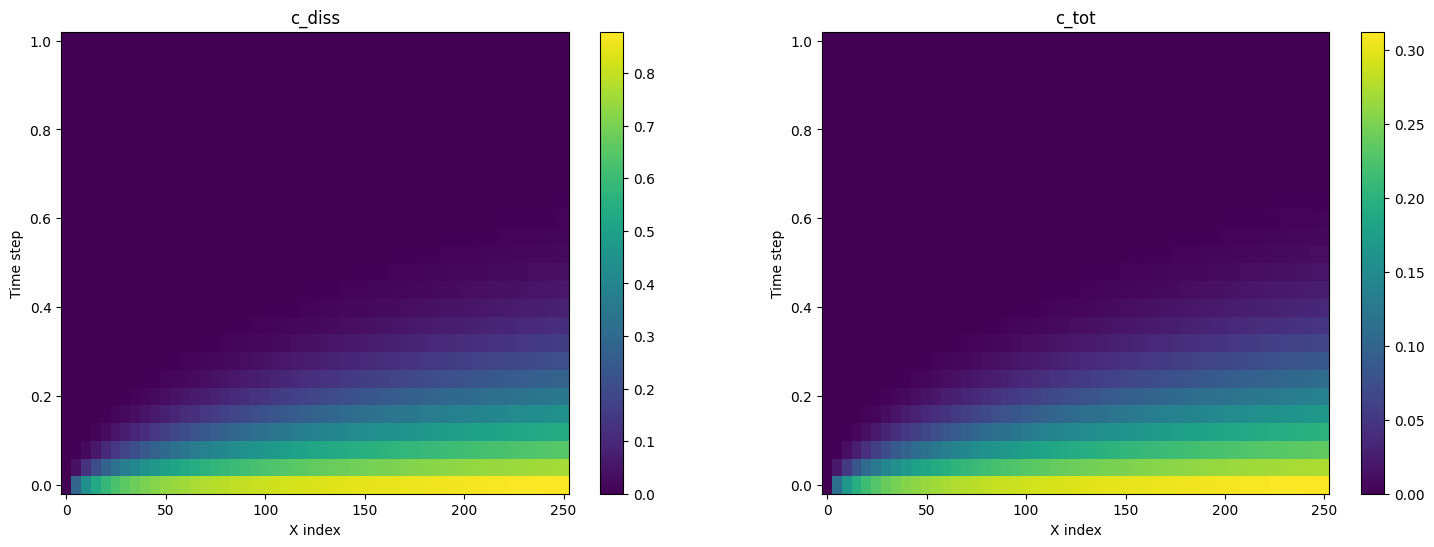

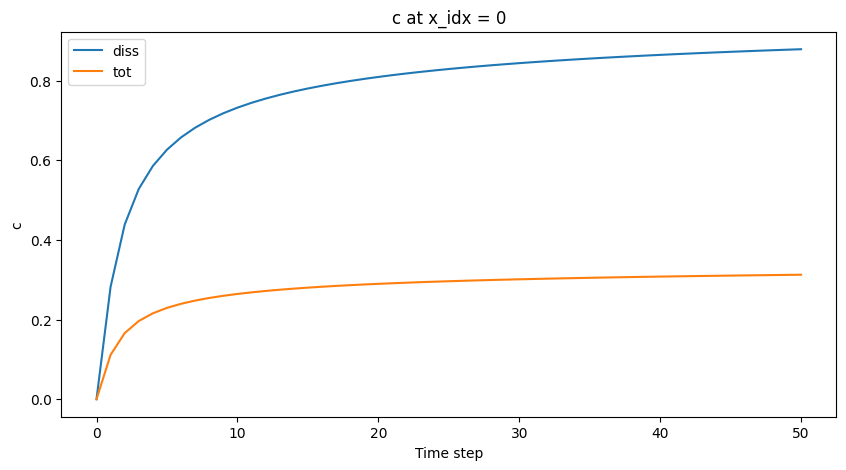

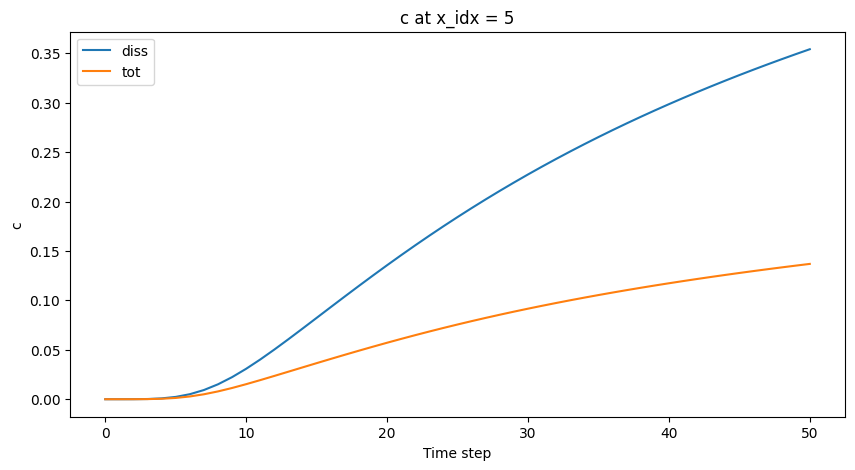

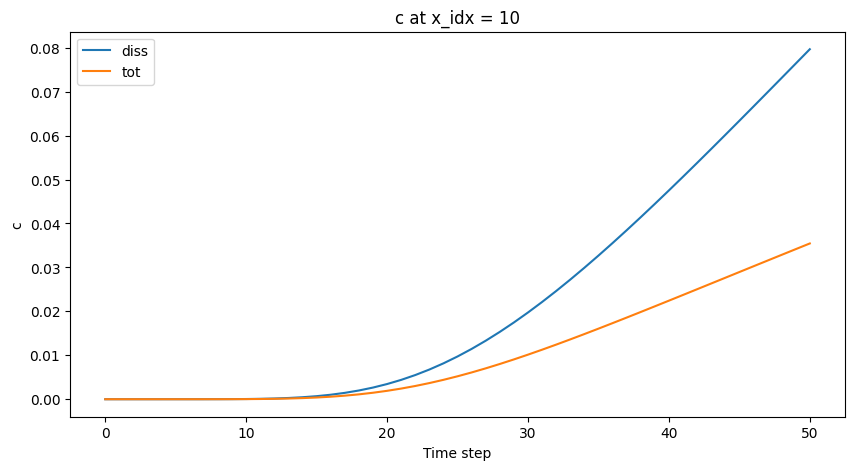

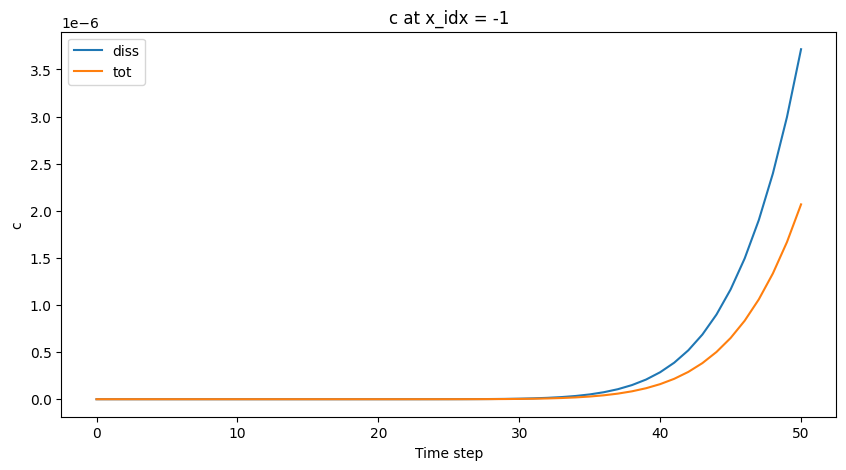

In [53]:
X, T = np.meshgrid(x, t_train)
plot_c(t=T, x=X, c=c_predictions[...,0])
plot_c_timeseries(c_predictions[...,0], x_idx=0)
plot_c_timeseries(c_predictions[...,0], x_idx=5)
plot_c_timeseries(c_predictions[...,0], x_idx=10)
plot_c_timeseries(c_predictions[...,0], x_idx=-1)
plt.show()

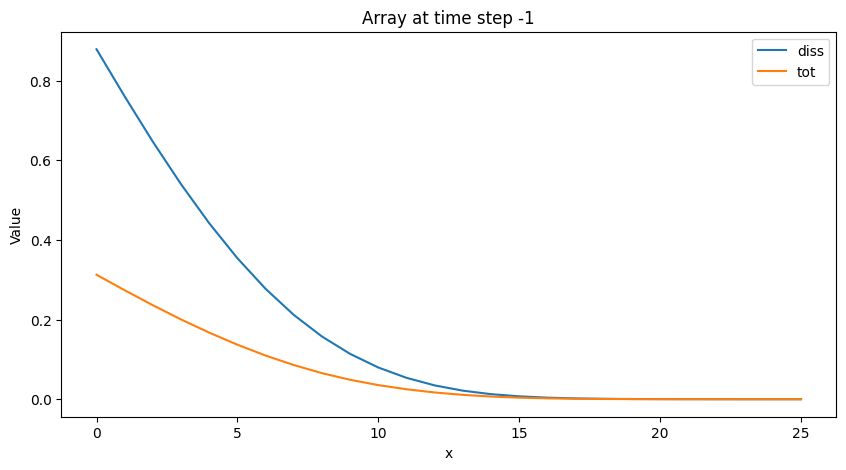

In [54]:
plot_c_spaceseries(c_predictions[...,0], t_idx=-1)

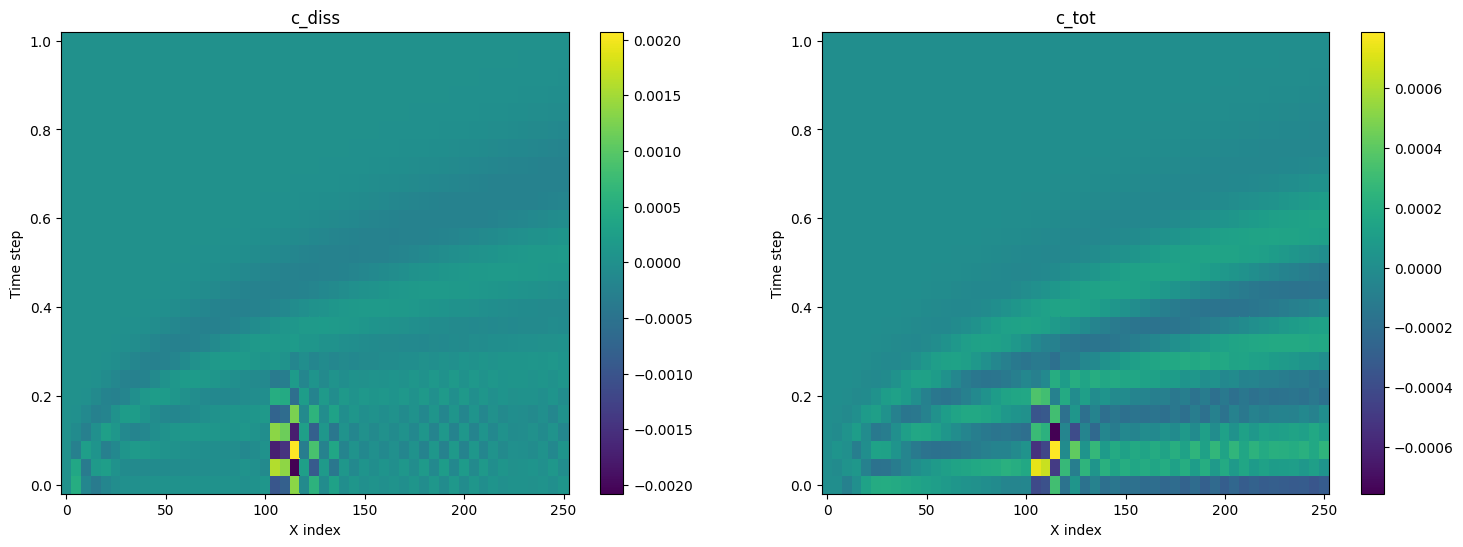

In [55]:
plot_c(t=T, x=X, c=residuals[...,0])

# Training Data

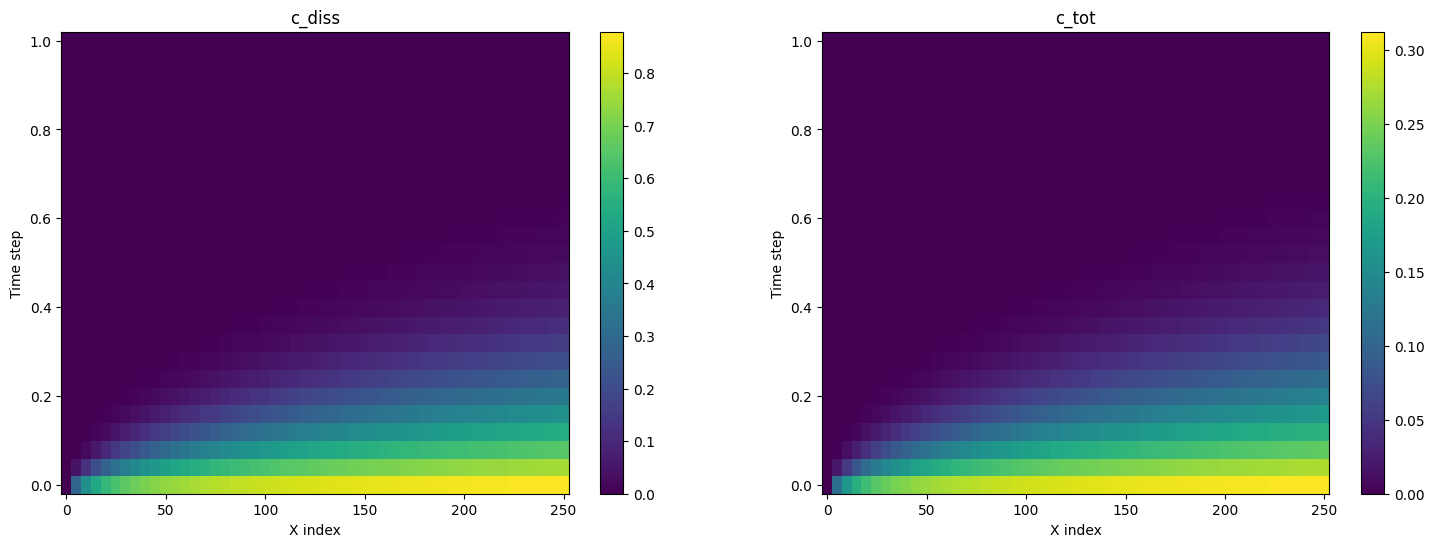

In [56]:
plot_c(t=T, x=X, c=c_train[...,0])